In [ ]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.set_project('copy-of-untitled10')
jovian.set_colab_id('1lo-sGRC9TzE2NED0GshO-zLdSk0xlajz')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import torch
import torchvision
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
import torchvision.models as models
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from torchvision.datasets.folder import default_loader
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
batch_size = 128
image_size = (64,64)
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [ ]:
transform_ds = transforms.Compose([transforms.Resize(image_size),
#                                    transforms.RandomCrop(32, padding=2),
#                                    transforms.RandomHorizontalFlip(),
                                   transforms.ToTensor(),
                                   transforms.Normalize(*stats)
                                   ])

train_ds = torchvision.datasets.ImageFolder(root="/content/drive/MyDrive/art/Abstract_gallery/",
                                     transform=transform_ds)

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
print(len(train_ds))

2782


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 64, 64])


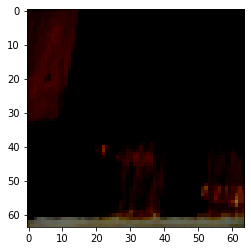

In [ ]:
images,_ = train_ds[40]
print(images.size())
plt.imshow(images.permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


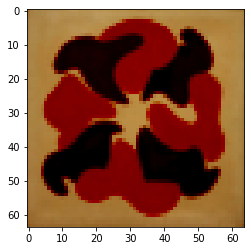

In [ ]:
images,_ = train_ds[872]
plt.imshow(images.permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


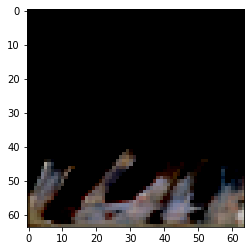

In [ ]:
images,_ = train_ds[31]
plt.imshow(images.permute(1,2,0))

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [ ]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

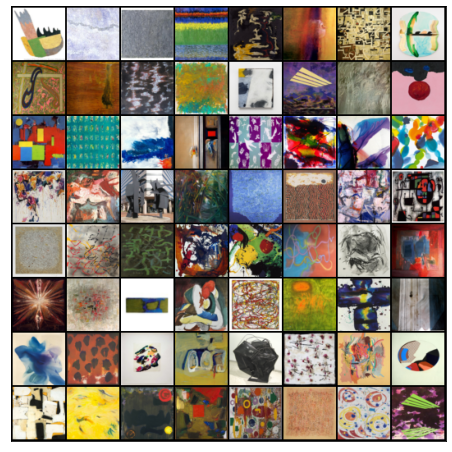

In [ ]:
show_batch(train_dl)

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

In [ ]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [ ]:
discriminator = to_device(discriminator, device)

In [ ]:
latent_size = 150

In [ ]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


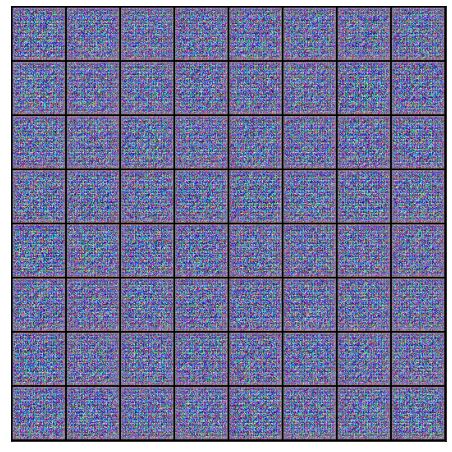

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [ ]:
generator = to_device(generator, device)

In [ ]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [ ]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [ ]:
from torchvision.utils import save_image

In [ ]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


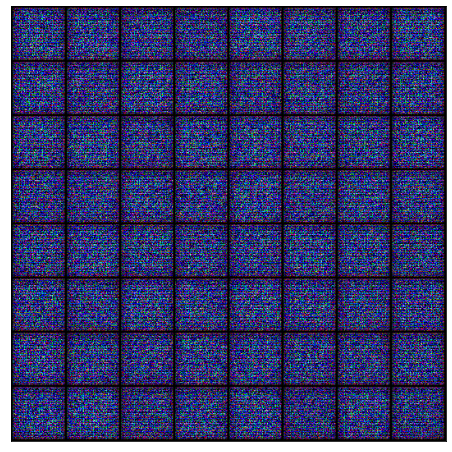

In [ ]:
save_samples(0, fixed_latent)

In [ ]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [ ]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
!pip install jovian --upgrade --quiet

In [ ]:
import jovian

In [ ]:
jovian.commit(project="project-GANs for Art", environment=None)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/dschirmerii/project-gans-for-art


'https://jovian.ai/dschirmerii/project-gans-for-art'

In [ ]:
lr = 0.001
epochs = 100

In [ ]:
jovian.reset()
jovian.log_hyperparams(lr=lr, epochs=epochs)

[jovian] Hyperparams logged.


In [ ]:
history = fit(epochs,lr)

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [1/100], loss_g: 4.4276, loss_d: 0.2070, real_score: 0.8360, fake_score: 0.0160
Saving generated-images-0001.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [2/100], loss_g: 3.4602, loss_d: 2.3120, real_score: 0.1634, fake_score: 0.0071
Saving generated-images-0002.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [3/100], loss_g: 2.7990, loss_d: 1.1161, real_score: 0.4195, fake_score: 0.0085
Saving generated-images-0003.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [4/100], loss_g: 1.5179, loss_d: 1.1752, real_score: 0.4020, fake_score: 0.0718
Saving generated-images-0004.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [5/100], loss_g: 5.8758, loss_d: 0.3160, real_score: 0.8707, fake_score: 0.1404
Saving generated-images-0005.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [6/100], loss_g: 5.6296, loss_d: 0.3714, real_score: 0.8632, fake_score: 0.1824
Saving generated-images-0006.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [7/100], loss_g: 2.6752, loss_d: 0.7583, real_score: 0.9289, fake_score: 0.4416
Saving generated-images-0007.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [8/100], loss_g: 2.5436, loss_d: 0.8551, real_score: 0.8557, fake_score: 0.4908
Saving generated-images-0008.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [9/100], loss_g: 1.3657, loss_d: 1.2141, real_score: 0.5270, fake_score: 0.3625
Saving generated-images-0009.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [10/100], loss_g: 1.2809, loss_d: 0.8300, real_score: 0.7275, fake_score: 0.3642
Saving generated-images-0010.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [11/100], loss_g: 2.9994, loss_d: 0.7315, real_score: 0.7562, fake_score: 0.3086
Saving generated-images-0011.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [12/100], loss_g: 3.8235, loss_d: 1.3842, real_score: 0.7510, fake_score: 0.6096
Saving generated-images-0012.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [13/100], loss_g: 1.3924, loss_d: 1.1531, real_score: 0.5677, fake_score: 0.3150
Saving generated-images-0013.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [14/100], loss_g: 1.4435, loss_d: 0.9709, real_score: 0.4579, fake_score: 0.0350
Saving generated-images-0014.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [15/100], loss_g: 1.6524, loss_d: 0.7957, real_score: 0.5580, fake_score: 0.1133
Saving generated-images-0015.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [16/100], loss_g: 3.5732, loss_d: 0.6837, real_score: 0.7419, fake_score: 0.2721
Saving generated-images-0016.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [17/100], loss_g: 2.1449, loss_d: 0.8982, real_score: 0.6616, fake_score: 0.3276
Saving generated-images-0017.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [18/100], loss_g: 3.1816, loss_d: 1.0383, real_score: 0.7552, fake_score: 0.4625
Saving generated-images-0018.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [19/100], loss_g: 2.6498, loss_d: 0.6667, real_score: 0.7449, fake_score: 0.2740
Saving generated-images-0019.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [20/100], loss_g: 0.7026, loss_d: 1.3561, real_score: 0.4441, fake_score: 0.2575
Saving generated-images-0020.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [21/100], loss_g: 0.9766, loss_d: 1.0485, real_score: 0.6329, fake_score: 0.3515
Saving generated-images-0021.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [22/100], loss_g: 3.4781, loss_d: 0.7814, real_score: 0.7021, fake_score: 0.2863
Saving generated-images-0022.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [23/100], loss_g: 0.6981, loss_d: 1.0322, real_score: 0.4881, fake_score: 0.1902
Saving generated-images-0023.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [24/100], loss_g: 1.9301, loss_d: 0.9206, real_score: 0.5358, fake_score: 0.1851
Saving generated-images-0024.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [25/100], loss_g: 2.3584, loss_d: 1.2383, real_score: 0.6892, fake_score: 0.5075
Saving generated-images-0025.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [26/100], loss_g: 1.8722, loss_d: 1.3150, real_score: 0.4478, fake_score: 0.2903
Saving generated-images-0026.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [27/100], loss_g: 3.6747, loss_d: 1.2089, real_score: 0.8042, fake_score: 0.5818
Saving generated-images-0027.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [28/100], loss_g: 3.3879, loss_d: 1.1036, real_score: 0.7992, fake_score: 0.5382
Saving generated-images-0028.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [29/100], loss_g: 3.1875, loss_d: 1.3481, real_score: 0.9162, fake_score: 0.6634
Saving generated-images-0029.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [30/100], loss_g: 2.0233, loss_d: 1.4078, real_score: 0.7467, fake_score: 0.5722
Saving generated-images-0030.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [31/100], loss_g: 5.3493, loss_d: 1.1475, real_score: 0.8700, fake_score: 0.5174
Saving generated-images-0031.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [32/100], loss_g: 3.1297, loss_d: 1.4304, real_score: 0.8278, fake_score: 0.6095
Saving generated-images-0032.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [33/100], loss_g: 1.3296, loss_d: 1.2119, real_score: 0.4528, fake_score: 0.1748
Saving generated-images-0033.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [34/100], loss_g: 2.2932, loss_d: 0.7084, real_score: 0.7805, fake_score: 0.3305
Saving generated-images-0034.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [35/100], loss_g: 1.2771, loss_d: 1.1720, real_score: 0.4283, fake_score: 0.1859
Saving generated-images-0035.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [36/100], loss_g: 1.9015, loss_d: 1.0087, real_score: 0.5898, fake_score: 0.3298
Saving generated-images-0036.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [37/100], loss_g: 2.0101, loss_d: 0.6539, real_score: 0.8180, fake_score: 0.3252
Saving generated-images-0037.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [38/100], loss_g: 2.8557, loss_d: 1.8728, real_score: 0.8059, fake_score: 0.7490
Saving generated-images-0038.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [39/100], loss_g: 2.1046, loss_d: 0.7606, real_score: 0.6921, fake_score: 0.2792
Saving generated-images-0039.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [40/100], loss_g: 3.6020, loss_d: 0.4614, real_score: 0.8436, fake_score: 0.2152
Saving generated-images-0040.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [41/100], loss_g: 1.3071, loss_d: 1.7682, real_score: 0.2506, fake_score: 0.0846
Saving generated-images-0041.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [42/100], loss_g: 1.3069, loss_d: 1.4784, real_score: 0.2880, fake_score: 0.0592
Saving generated-images-0042.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [43/100], loss_g: 2.2372, loss_d: 0.9258, real_score: 0.6737, fake_score: 0.3103
Saving generated-images-0043.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [44/100], loss_g: 2.6359, loss_d: 0.9394, real_score: 0.6992, fake_score: 0.3258
Saving generated-images-0044.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [45/100], loss_g: 2.6812, loss_d: 0.7102, real_score: 0.7336, fake_score: 0.2892
Saving generated-images-0045.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [46/100], loss_g: 1.2293, loss_d: 1.3306, real_score: 0.3962, fake_score: 0.1815
Saving generated-images-0046.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [47/100], loss_g: 1.8271, loss_d: 1.0933, real_score: 0.5311, fake_score: 0.2858
Saving generated-images-0047.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [48/100], loss_g: 2.4363, loss_d: 1.2991, real_score: 0.7832, fake_score: 0.5984
Saving generated-images-0048.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [49/100], loss_g: 1.6920, loss_d: 1.0580, real_score: 0.4590, fake_score: 0.1599
Saving generated-images-0049.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [50/100], loss_g: 3.5886, loss_d: 1.5633, real_score: 0.7800, fake_score: 0.6661
Saving generated-images-0050.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [51/100], loss_g: 3.4659, loss_d: 0.7697, real_score: 0.8377, fake_score: 0.4142
Saving generated-images-0051.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [52/100], loss_g: 1.7093, loss_d: 0.7496, real_score: 0.6366, fake_score: 0.2154
Saving generated-images-0052.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [53/100], loss_g: 1.8703, loss_d: 1.0617, real_score: 0.4544, fake_score: 0.1138
Saving generated-images-0053.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [54/100], loss_g: 4.2288, loss_d: 1.8505, real_score: 0.8358, fake_score: 0.7547
Saving generated-images-0054.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [55/100], loss_g: 5.7781, loss_d: 1.2235, real_score: 0.9393, fake_score: 0.6316
Saving generated-images-0055.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [56/100], loss_g: 2.3123, loss_d: 0.5234, real_score: 0.7892, fake_score: 0.2308
Saving generated-images-0056.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [57/100], loss_g: 2.8082, loss_d: 0.6171, real_score: 0.6910, fake_score: 0.1890
Saving generated-images-0057.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [58/100], loss_g: 4.2338, loss_d: 0.9613, real_score: 0.8464, fake_score: 0.5066
Saving generated-images-0058.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [59/100], loss_g: 3.5409, loss_d: 1.0860, real_score: 0.7544, fake_score: 0.4943
Saving generated-images-0059.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [60/100], loss_g: 5.6064, loss_d: 1.2845, real_score: 0.9620, fake_score: 0.6777
Saving generated-images-0060.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [61/100], loss_g: 6.3193, loss_d: 1.0282, real_score: 0.9561, fake_score: 0.5623
Saving generated-images-0061.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [62/100], loss_g: 3.3870, loss_d: 0.9224, real_score: 0.9262, fake_score: 0.5246
Saving generated-images-0062.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [63/100], loss_g: 2.4232, loss_d: 1.4531, real_score: 0.5346, fake_score: 0.3972
Saving generated-images-0063.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [64/100], loss_g: 2.1227, loss_d: 0.6468, real_score: 0.7345, fake_score: 0.2440
Saving generated-images-0064.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [65/100], loss_g: 2.8197, loss_d: 1.3355, real_score: 0.8110, fake_score: 0.6200
Saving generated-images-0065.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [66/100], loss_g: 4.7095, loss_d: 0.8403, real_score: 0.9270, fake_score: 0.4742
Saving generated-images-0066.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [67/100], loss_g: 1.9140, loss_d: 0.8921, real_score: 0.5775, fake_score: 0.2110
Saving generated-images-0067.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [68/100], loss_g: 3.4485, loss_d: 0.7190, real_score: 0.5795, fake_score: 0.0706
Saving generated-images-0068.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [69/100], loss_g: 3.6517, loss_d: 1.3467, real_score: 0.8170, fake_score: 0.6239
Saving generated-images-0069.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [70/100], loss_g: 1.4377, loss_d: 1.9939, real_score: 0.1980, fake_score: 0.0424
Saving generated-images-0070.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [71/100], loss_g: 4.0306, loss_d: 1.1552, real_score: 0.7486, fake_score: 0.5161
Saving generated-images-0071.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [72/100], loss_g: 4.2474, loss_d: 1.4460, real_score: 0.8110, fake_score: 0.6663
Saving generated-images-0072.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [73/100], loss_g: 1.6486, loss_d: 1.0458, real_score: 0.5656, fake_score: 0.3086
Saving generated-images-0073.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [74/100], loss_g: 5.4849, loss_d: 1.3044, real_score: 0.8232, fake_score: 0.6247
Saving generated-images-0074.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [75/100], loss_g: 2.7956, loss_d: 0.9297, real_score: 0.7009, fake_score: 0.3900
Saving generated-images-0075.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [76/100], loss_g: 2.0802, loss_d: 1.0431, real_score: 0.5316, fake_score: 0.2309
Saving generated-images-0076.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [77/100], loss_g: 3.1740, loss_d: 0.7339, real_score: 0.7015, fake_score: 0.2443
Saving generated-images-0077.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [78/100], loss_g: 2.7392, loss_d: 0.7408, real_score: 0.7364, fake_score: 0.3065
Saving generated-images-0078.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [79/100], loss_g: 2.0226, loss_d: 0.9849, real_score: 0.5414, fake_score: 0.2017
Saving generated-images-0079.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [80/100], loss_g: 1.6677, loss_d: 0.8480, real_score: 0.5758, fake_score: 0.1763
Saving generated-images-0080.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [81/100], loss_g: 2.8482, loss_d: 0.8137, real_score: 0.6660, fake_score: 0.2687
Saving generated-images-0081.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [82/100], loss_g: 6.0635, loss_d: 2.1664, real_score: 0.9470, fake_score: 0.8134
Saving generated-images-0082.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [83/100], loss_g: 1.6256, loss_d: 1.3432, real_score: 0.4476, fake_score: 0.2685
Saving generated-images-0083.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [84/100], loss_g: 0.4259, loss_d: 1.8765, real_score: 0.2355, fake_score: 0.1280
Saving generated-images-0084.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [85/100], loss_g: 4.1653, loss_d: 0.7799, real_score: 0.8311, fake_score: 0.3905
Saving generated-images-0085.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [86/100], loss_g: 2.1012, loss_d: 2.1821, real_score: 0.1656, fake_score: 0.0156
Saving generated-images-0086.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [87/100], loss_g: 3.3004, loss_d: 0.9217, real_score: 0.6842, fake_score: 0.3423
Saving generated-images-0087.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [88/100], loss_g: 1.7165, loss_d: 1.0867, real_score: 0.5267, fake_score: 0.2702
Saving generated-images-0088.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [89/100], loss_g: 3.6507, loss_d: 0.8625, real_score: 0.8345, fake_score: 0.4282
Saving generated-images-0089.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [90/100], loss_g: 2.3158, loss_d: 0.6921, real_score: 0.6619, fake_score: 0.1666
Saving generated-images-0090.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [91/100], loss_g: 3.8140, loss_d: 0.9664, real_score: 0.7980, fake_score: 0.4536
Saving generated-images-0091.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [92/100], loss_g: 3.4058, loss_d: 0.8007, real_score: 0.6186, fake_score: 0.1948
Saving generated-images-0092.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [93/100], loss_g: 2.4205, loss_d: 0.7762, real_score: 0.6198, fake_score: 0.1895
Saving generated-images-0093.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [94/100], loss_g: 2.1118, loss_d: 1.1575, real_score: 0.4123, fake_score: 0.0880
Saving generated-images-0094.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [95/100], loss_g: 3.5148, loss_d: 0.6768, real_score: 0.8443, fake_score: 0.3442
Saving generated-images-0095.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [96/100], loss_g: 3.8596, loss_d: 0.8827, real_score: 0.7438, fake_score: 0.3569
Saving generated-images-0096.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [97/100], loss_g: 2.3399, loss_d: 0.5816, real_score: 0.6945, fake_score: 0.1470
Saving generated-images-0097.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [98/100], loss_g: 2.0973, loss_d: 0.8379, real_score: 0.7546, fake_score: 0.3460
Saving generated-images-0098.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [99/100], loss_g: 4.1771, loss_d: 1.0210, real_score: 0.9147, fake_score: 0.5381
Saving generated-images-0099.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch [100/100], loss_g: 2.1385, loss_d: 0.8587, real_score: 0.5818, fake_score: 0.1908
Saving generated-images-0100.png


In [ ]:
from IPython.display import Image 

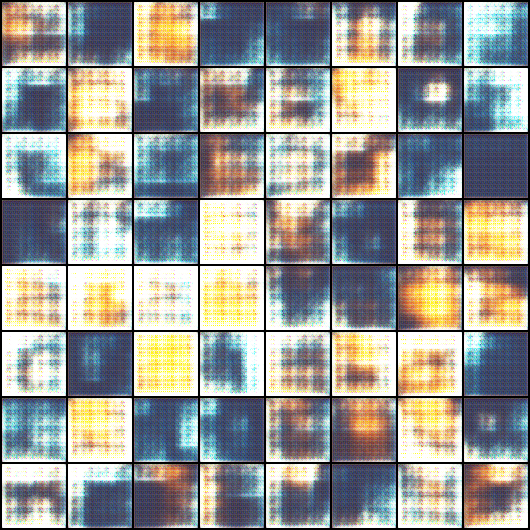

In [ ]:
Image('./generated/generated-images-0013.png')

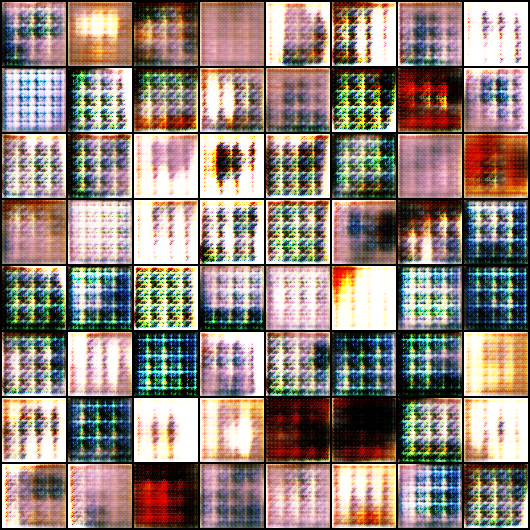

In [ ]:
Image('./generated/generated-images-0037.png')

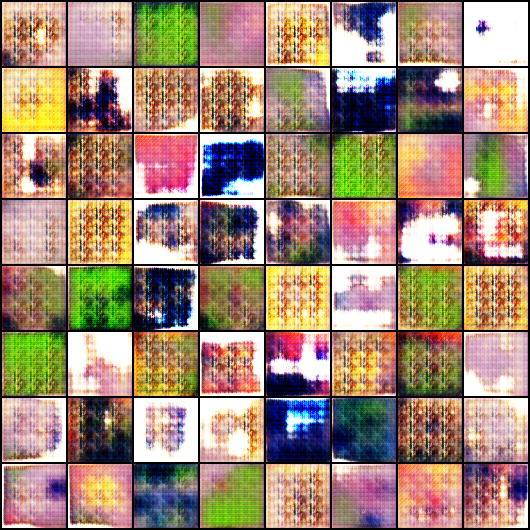

In [ ]:
Image('./generated/generated-images-0072.png')

In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

In [ ]:
jovian.log_metrics(loss_g=losses_g[-1], 
                   loss_d=losses_d[-1], 
                   real_score=real_scores[-1], 
                   fake_score=fake_scores[-1])

[jovian] Metrics logged.


In [ ]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.ckpt')
torch.save(discriminator.state_dict(), 'D.ckpt')

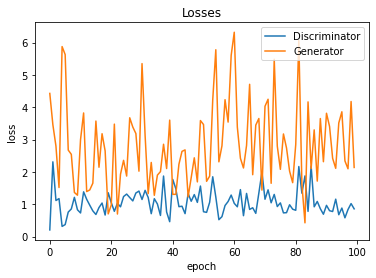

In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

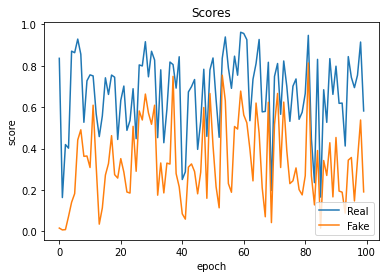

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

In [ ]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()